# Ensembles

En esta notebook, veremos de hacer un ensemble neuronal de las técnicas vistas hasta el momento (y quizás alguna más)

Vamos a usar

- Modelo char
- Modelo BoW
- Modelo ElMO


In [1]:
import pandas as pd
import csv
import numpy as np
import tensorflow as tf
import random
import torch

torch.manual_seed(2019)
np.random.seed(2019)
tf.random.set_random_seed(2019)
random.seed(2019)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

df_dev = pd.read_table("../../../data/es/dev_es.tsv", index_col="id", quoting=csv.QUOTE_NONE)
df_train = pd.read_table("../../../data/es/train_es.tsv", index_col="id", quoting=csv.QUOTE_NONE)
df_test = pd.read_table("../../../data/es/reference_es.tsv", header=None, 
                        names=["text", "HS", "TR", "AG"], quoting=csv.QUOTE_NONE)


text_train, y_train = df_train["text"], df_train["HS"]
text_dev, y_dev = df_dev["text"], df_dev["HS"]
text_test, y_test = df_test["text"], df_test["HS"]

print("Instancias de entrenamiento: {}".format(len(df_train)))
print("Instancias de desarrollo: {}".format(len(df_dev)))
print("Instancias de test: {}".format(len(df_test)))



Instancias de entrenamiento: 4500
Instancias de desarrollo: 500
Instancias de test: 1600


Hagamos tokenize sobre el texto

In [2]:
from nltk.tokenize import TweetTokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from nltk.stem import SnowballStemmer
import unidecode

stemmer = SnowballStemmer('spanish')

def tokenize(tweet, stem=False, deaccent=True, alpha_only=False, **kwargs):
    tokenizer = TweetTokenizer(**kwargs)
    tokens = tokenizer.tokenize(tweet)
    
    ret = []
    
    def fstem(x):
        if stem:
            return stemmer.stem(x)
        else:
            return x
        
    for token in tokens:
        tok = None
        if token[0] == "#":            
            tok = fstem(token[1:])
        elif token[0] == "@":
            tok = "@user"
        elif "http" in token:
            continue
        else:
            tok = fstem(token)
        
        if deaccent and tok.isalpha():
            tok = unidecode.unidecode(tok)
        if alpha_only and not tok.isalpha():
            continue
        
        ret.append(tok)
    return ret



Using TensorFlow backend.


## Bow Model

In [3]:

tokenize_args = {"preserve_case": False, "reduce_len": True, "strip_handles": False}

vect = CountVectorizer(tokenizer=lambda t: tokenize(t, stem=True, **tokenize_args), 
                       max_df=0.90, min_df=0.001, ngram_range=(1, 2), binary=True)

vect.fit(df_train["text"])

X_bow_train = vect.transform(df_train["text"])
X_bow_dev = vect.transform(df_dev["text"])
X_bow_test = vect.transform(df_test["text"])

## Char Input

In [4]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

vocab_size = 200


tokenize_args = {
    "preserve_case": False, 
    "deaccent": True,
    "reduce_len": True, 
    "strip_handles": False,
    "stem": True,
    "alpha_only": False
}

text_train = [" ".join(tokenize(t, **tokenize_args)) for t in df_train["text"].values]
text_dev = [" ".join(tokenize(t, **tokenize_args)) for t in df_dev["text"].values]
text_test = [" ".join(tokenize(t, **tokenize_args)) for t in df_test["text"].values]
char_tokenizer = Tokenizer(num_words=vocab_size, char_level=True, 
                           lower=tokenize_args["preserve_case"])
char_tokenizer.fit_on_texts(text_train)

X_char_train = char_tokenizer.texts_to_sequences(text_train)
X_char_dev = char_tokenizer.texts_to_sequences(text_dev)
X_char_test = char_tokenizer.texts_to_sequences(text_test)

(array([358., 909., 892., 801., 491., 274., 256., 264., 220.,  35.]),
 array([  5. ,  32.1,  59.2,  86.3, 113.4, 140.5, 167.6, 194.7, 221.8,
        248.9, 276. ]),
 <a list of 10 Patch objects>)

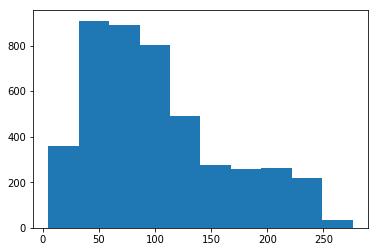

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.hist([len(seq) for seq in X_char_train])

Sanity check: veamos que si "destokenizo", me reconstruye algo razonable

In [6]:

max_charlen = 300

X_char_train = pad_sequences(X_char_train, maxlen=max_charlen)
X_char_dev = pad_sequences(X_char_dev, maxlen=max_charlen)
X_char_test = pad_sequences(X_char_test, maxlen=max_charlen)

## Elmo Input

In [7]:
from keras.utils import to_categorical
import numpy as np

tokenize_args = {
    "preserve_case": False, 
    "deaccent": False,
    "reduce_len": True, 
    "strip_handles": False,
    "alpha_only": True,
}


tokens_train = [tokenize(tweet, **tokenize_args) for tweet in df_train["text"].values]
tokens_dev = [tokenize(tweet, **tokenize_args) for tweet in df_dev["text"].values]
tokens_test = [tokenize(tweet, **tokenize_args) for tweet in df_test["text"].values]


tokens_train[0]

['easyjet',
 'quiere',
 'duplicar',
 'el',
 'número',
 'de',
 'mujeres',
 'piloto',
 'verás',
 'tú',
 'para',
 'aparcar',
 'el',
 'avión']

Ahora, calculemos los inputs de ElMO

(array([505., 959., 927., 772., 417., 336., 285., 200.,  82.,  17.]),
 array([ 1. ,  6.8, 12.6, 18.4, 24.2, 30. , 35.8, 41.6, 47.4, 53.2, 59. ]),
 <a list of 10 Patch objects>)

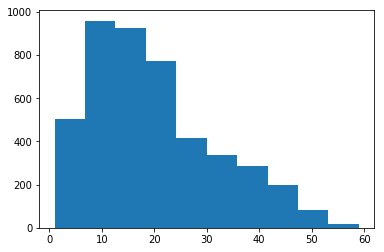

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.hist([len(t) for t in tokens_train])

Padeamos los vectores con espacios

In [9]:
elmo_max_length = 50

def pad_tokens(tokens, max_len):
    if len(tokens) >= max_len:
        return tokens[:max_len]
    else:
        tokens = tokens + [''] * (max_len - len(tokens))
    return tokens

padded_tokens_train = [pad_tokens(seq, elmo_max_length) for seq in tokens_train]
padded_tokens_dev = [pad_tokens(seq, elmo_max_length) for seq in tokens_dev]
padded_tokens_test = [pad_tokens(seq, elmo_max_length) for seq in tokens_test]


In [10]:
%%capture
from elmoformanylangs import Embedder

e = Embedder("../../../models/elmo/es/")

In [11]:
import numpy as np

print(padded_tokens_train[0])

elmo_dim = 1024

elmo_train = np.array(e.sents2elmo(padded_tokens_train, -1))
elmo_dev = np.array(e.sents2elmo(padded_tokens_dev, -1))
elmo_test = np.array(e.sents2elmo(padded_tokens_test, -1))

['easyjet', 'quiere', 'duplicar', 'el', 'número', 'de', 'mujeres', 'piloto', 'verás', 'tú', 'para', 'aparcar', 'el', 'avión', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']


(array([8.8105e+04, 5.0126e+04, 2.1559e+04, 3.0594e+04, 2.4568e+04,
        8.9650e+03, 1.0060e+03, 7.1000e+01, 4.0000e+00, 2.0000e+00]),
 array([13.046073, 16.202387, 19.3587  , 22.515013, 25.671326, 28.82764 ,
        31.983953, 35.140266, 38.29658 , 41.452892, 44.609207],
       dtype=float32),
 <a list of 10 Patch objects>)

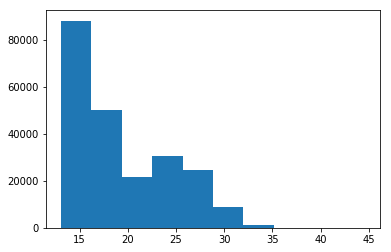

In [12]:
plt.hist([np.linalg.norm(t) for seq in elmo_train for t in seq ])

In [13]:

def pad_vectors(X, max_len, norm=False):
    pad_vector = np.zeros((1, elmo_dim))
    ret = []
    
    for seq in X:
        if norm:
            seq = seq / np.linalg.norm(seq, axis=1)[..., np.newaxis]
        if len(seq) > max_len:
            ret.append(seq[:max_len])
        else:
            padded = np.vstack([
                seq, 
                np.zeros((max_len - len(seq), elmo_dim))
            ])
            
            ret.append(padded)
        
    return ret


X_elmo_train = np.array(pad_vectors(elmo_train, elmo_max_length))
X_elmo_dev = np.array(pad_vectors(elmo_dev, elmo_max_length))
X_elmo_test = np.array(pad_vectors(elmo_test, elmo_max_length))

X_elmo_train.shape, X_elmo_dev.shape

((4500, 50, 1024), (500, 50, 1024))

(array([8.8105e+04, 5.0126e+04, 2.1559e+04, 3.0594e+04, 2.4568e+04,
        8.9650e+03, 1.0060e+03, 7.1000e+01, 4.0000e+00, 2.0000e+00]),
 array([13.04607293, 16.20238631, 19.35869969, 22.51501308, 25.67132646,
        28.82763985, 31.98395323, 35.14026662, 38.29658   , 41.45289338,
        44.60920677]),
 <a list of 10 Patch objects>)

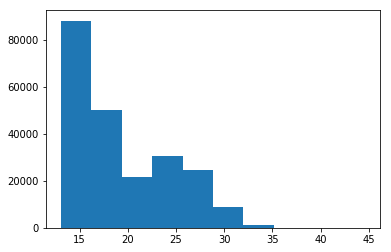

In [14]:
norms = [np.linalg.norm(t) for seq in X_elmo_train for t in seq ]

plt.hist(norms)

## Modelo múltiple inputs
Hagamos un primer modelo con múltiple inputs.

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Char_Input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 300, 64)      12800       Char_Input[0][0]                 
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 300, 128)     49280       embedding_1[0][0]                
__________________________________________________________________________________________________
max_pooling1d_1 (MaxPooling1D)  (None, 100, 128)     0           conv1d_1[0][0]                   
__________________________________________________________________________________________________
Elmo_Input

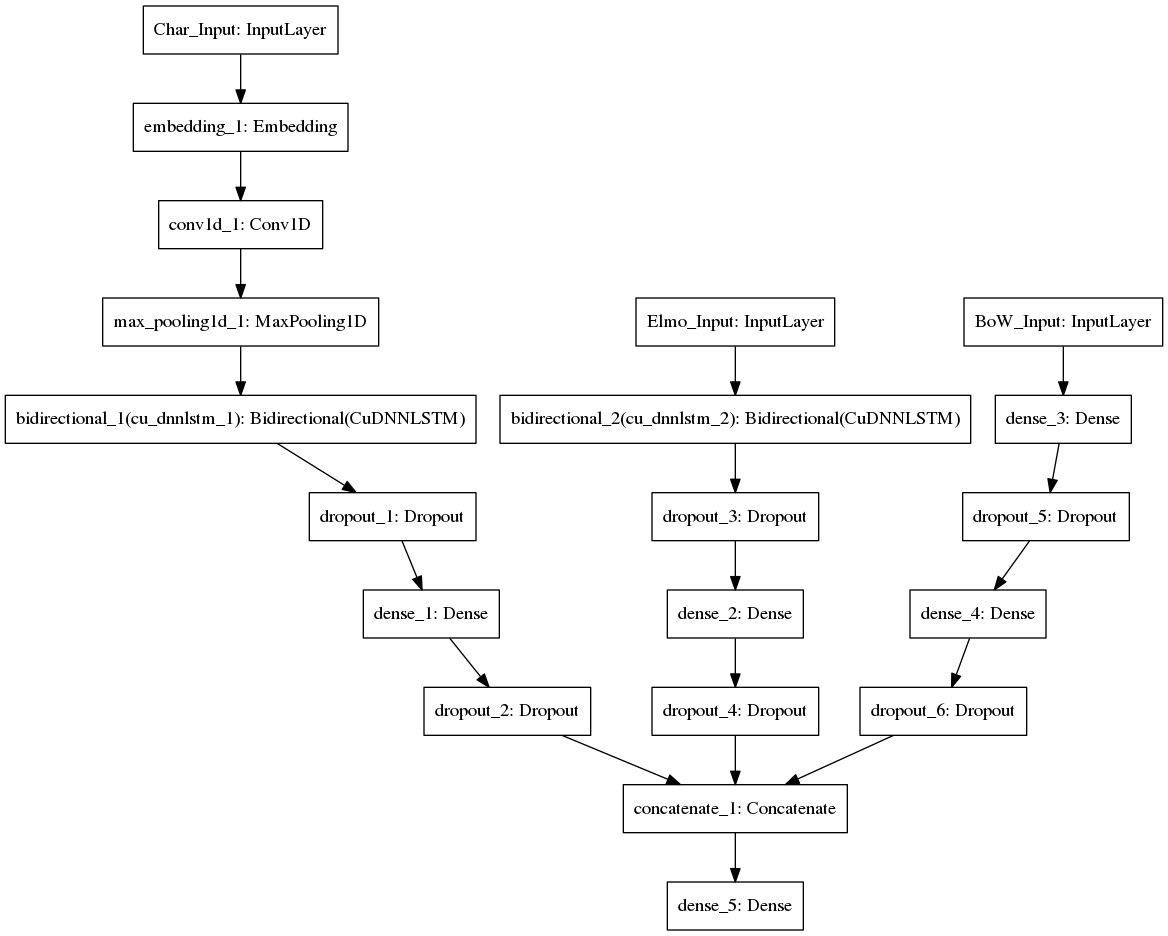

In [15]:
from keras.models import Model
from keras.layers import (
    Dense, GRU, Dropout, LSTM, Bidirectional, Embedding,
    CuDNNLSTM, CuDNNGRU, Conv1D, MaxPooling1D, Input, Concatenate)
from keras.optimizers import Adam
from keras.utils import plot_model

recursive_class = CuDNNLSTM

def create_char_graph(max_charlen, vocab_size, embedding_dim=64, filters=128, kernel_size=7,
                      pooling_size=3, lstm_units=128, dense_units=64, dropout=[0.75, 0.50]):
    input_char = Input(shape=(max_charlen,), name="Char_Input")
    x = Embedding(vocab_size, embedding_dim)(input_char)
    x = Conv1D(filters=filters, kernel_size=kernel_size, 
               padding='same', activation='relu')(x) 
    
    x = MaxPooling1D(pool_size=pooling_size)(x)
    x = Bidirectional(recursive_class(lstm_units))(x)
    x = Dropout(dropout[0])(x)
    x = Dense(dense_units, activation='relu')(x)
    x = Dropout(dropout[1])(x)
    
    return input_char, x


def create_elmo_graph(max_length, lstm_units=128, dropout=[0.75, 0.50]):
    input_elmo = Input(shape=(max_length, elmo_dim), name="Elmo_Input")
    y = Bidirectional(recursive_class(lstm_units))(input_elmo)
    y = Dropout(dropout[0])(y)
    y = Dense(128, activation='relu')(y)
    y= Dropout(dropout[1])(y)
    return input_elmo, y

def create_bow_graph(input_shape, dense_units=512, dropout=[0.75, 0.50]):
    input_bow = Input(shape=input_shape, name="BoW_Input")
    z = Dense(dense_units, activation='relu')(input_bow)
    z = Dropout(dropout[0])(z)
    z = Dense(128, activation='relu')(z)
    z = Dropout(dropout[1])(z)
    
    return input_bow, z




dropouts = [0.75, 0.50]

input_char, output_char = create_char_graph(
    max_charlen, vocab_size, embedding_dim=64, lstm_units=64, filters=128, kernel_size=6,
    dropout=dropouts)
input_elmo, output_elmo = create_elmo_graph(elmo_max_length, lstm_units=128, dropout=dropouts)
input_bow, output_bow = create_bow_graph(input_shape=(X_bow_train.shape[1],), dense_units=256, dropout=dropouts)



use_char = True
use_elmo = True
use_bow = True

X_tr = []
X_dev = []
X_test = []
to_merge = []
inputs = []
if use_char:
    to_merge.append(output_char)
    inputs.append(input_char)
    X_tr.append(X_char_train)
    X_dev.append(X_char_dev)
    X_test.append(X_char_test)
if use_elmo:
    to_merge.append(output_elmo)
    inputs.append(input_elmo)
    X_tr.append(X_elmo_train)
    X_dev.append(X_elmo_dev) 
    X_test.append(X_elmo_test)
if use_bow:
    to_merge.append(output_bow)
    inputs.append(input_bow)
    X_tr.append(X_bow_train)
    X_dev.append(X_bow_dev)
    X_test.append(X_bow_test)


    
if use_char + use_elmo + use_bow >= 2:
    merge_layer = Concatenate()(to_merge)
else:
    merge_layer = to_merge[0]
    
#merge_layer = Dense(64, activation='relu')(merge_layer)
output = Dense(1, activation='sigmoid')(merge_layer)

optimizer_args = {
    "lr": 0.0005,
    "decay": 0.01,
    "amsgrad": False
}



model = Model(inputs=inputs, outputs=[output])
model.compile(loss='binary_crossentropy', 
              optimizer=Adam(**optimizer_args), 
              metrics=['accuracy'])


from IPython.display import Image

print(model.summary())


plot_model(model, to_file='model.png')
Image('model.png')

In [16]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint('/tmp/ensemble_11.h5', save_best_only=True, monitor='val_acc', verbose=1)

model.fit(X_tr, y_train, callbacks=[checkpointer],
          validation_data=(X_dev, y_dev), epochs=65, batch_size=32)


Train on 4500 samples, validate on 500 samples
Epoch 1/65
4500/4500 [==============================] - 8s 2ms/step - loss: 0.6773 - acc: 0.5862 - val_loss: 0.6381 - val_acc: 0.6420

Epoch 00001: val_acc improved from -inf to 0.64200, saving model to /tmp/ensemble_11.h5
Epoch 2/65
4500/4500 [==============================] - 5s 1ms/step - loss: 0.6099 - acc: 0.6773 - val_loss: 0.5902 - val_acc: 0.6960

Epoch 00002: val_acc improved from 0.64200 to 0.69600, saving model to /tmp/ensemble_11.h5
Epoch 3/65
4500/4500 [==============================] - 5s 1ms/step - loss: 0.5522 - acc: 0.7271 - val_loss: 0.5415 - val_acc: 0.7420

Epoch 00003: val_acc improved from 0.69600 to 0.74200, saving model to /tmp/ensemble_11.h5
Epoch 4/65
4500/4500 [==============================] - 5s 1ms/step - loss: 0.4972 - acc: 0.7747 - val_loss: 0.5015 - val_acc: 0.7680

Epoch 00004: val_acc improved from 0.74200 to 0.76800, saving model to /tmp/ensemble_11.h5
Epoch 5/65
4500/4500 [==============================

In [18]:
from hate.utils import print_evaluation

model.load_weights('/tmp/ensemble_11.h5')

print("\nEn Dev\n\n")
print_evaluation(model, X_dev, y_dev)
print("\n\nEn Test\n\n")
print_evaluation(model, X_test, y_test)


En Dev


500/500 [==============================] - 0s 571us/step
Loss           : 0.4111
Accuracy       : 0.8360
Precision(1)   : 0.8182
Precision(1)   : 0.8500
Precision(avg) : 0.8341

Recall(1)      : 0.8108
Recall(0)      : 0.8561
Recall(avg)    : 0.8335

F1(1)          : 0.8145
F1(0)          : 0.8530
F1(avg)        : 0.8338


En Test


1600/1600 [==============================] - 1s 540us/step
Loss           : 0.5768
Accuracy       : 0.7087
Precision(1)   : 0.6325
Precision(1)   : 0.7730
Precision(avg) : 0.7028

Recall(1)      : 0.7015
Recall(0)      : 0.7138
Recall(avg)    : 0.7077

F1(1)          : 0.6652
F1(0)          : 0.7423
F1(avg)        : 0.7037


In [19]:
model.save_weights("../../../models/nn/ensemble_11.h5")

## Error Analysis

Vamos a ver los tweets con mayores errores

In [39]:
df_dev["proba"] = model.predict(X_dev)


true_positives = df_dev[(df_dev["HS"] == 1) & (df_dev["proba"] >= 0.5)].copy()
true_negatives = df_dev[(df_dev["HS"] == 0) & (df_dev["proba"] < 0.5)].copy()

false_positives = df_dev[(df_dev["HS"] == 0) & (df_dev["proba"] > 0.5)].copy()
false_positives.sort_values("proba", ascending=False, inplace=True)


false_negatives = df_dev[(df_dev["HS"] == 1) & (df_dev["proba"] < 0.5)].copy()
false_negatives.sort_values("proba", ascending=True, inplace=True)

conf_matrix = pd.DataFrame([
    {"real":"hs=1", "pred_true": len(true_positives), "pred_false": len(false_negatives)},
    {"real":"hs=0", "pred_true": len(false_positives), "pred_false": len(true_negatives)}
])



conf_matrix.set_index("real", inplace=True)

print("Falsos negativos: {}".format(len(false_negatives)))
print("Falsos positivos: {}".format(len(false_positives)))

conf_matrix[["pred_true", "pred_false"]]

Falsos negativos: 41
Falsos positivos: 35


,pred_true,pred_false
real,,
hs=1,181,41
hs=0,35,243


## Falsos Negativos

Veamos los 20 falsos negativos en los cuales nuestro modelo se equivoca más

In [40]:
pd.set_option('max_colwidth', 300)

false_negatives[["text", "proba"]]


,text,proba
id,,
21072,"Voy andando por la calle y me han dicho cosas en árabe ya que me estas acosando dime lo en español para que te entienda, asique como yo no les entiendo me he cagado en su puta madre en árabe para que ellos a mi si.",0.002940
21215,"Que tal otro aporte anónimo son de la puta de mi esposa, así los dejó en navidad enseñando le los calzones al vecino rt y siguenos @TANGASUCIA @Tangasrobadas https://t.co/70ioUjveqY",0.014165
23716,"- El otro día me comí a Laura es muy fácil que guarra jajajaja - Laura también te comió a ti entonces tú eres igual de guarro e igual de fácil. - Puto feminazi putas modas eres feminista solo para ligar bien queda gilipollas - em, ok",0.014915
24925,"La verdad que si, no veia la hora de llegar a los 5 mil amigos😂 ahora de a poco voy borrando esos indios indocumentados😂 https://t.co/Xw8q4GLM8v",0.020792
22065,| lo único que dominas es mi polla en tu cara. https://t.co/qlYOd4zPwW,0.033408
20711,@lopezdoriga eso es culpa de los gobiernos corruptos que tienen arreglos con esta escoria. Ojalá se muera la perra esa...,0.046482
24352,"¿Ves que tu coño me importe? Cómete mi polla, basura https://t.co/ht02KyYWZh",0.056424
21887,"@A3Noticias Esta tiene que ser una 'fake new' porque las mujeres son siempre las víctimas, no las hijas de puta maltratadoras. Eso o el chaval es un machista que se lo ha merecido (machete al machote).",0.082768
20213,"@britneyspears Perra te lo mereces, esa presentación de WORK BICTH estuvo a tu altura, por fin le hiciste justicia a la canción y al álbum Britney Jean al presentar la canción en un programa de TV luciendo hermosa, acuerpada y subliminal",0.101024


¿Cómo los tokenizamos?

In [41]:
df_dev.loc[21841]["text"]

'La otra no noticia del día es la visita del sonriente Casado a Algeciras, a visitar en Ceuta y Algeciras, no a los guardias civiles heridos tras la violenta entrada de ilegales del otro día, sino a un grupo de subsaharianos que han entrado en nuestro país de forma igualmente ileg'

## Falsos positivos

In [42]:
pd.set_option('max_colwidth', 300)
false_positives[["text", "proba"]]

,text,proba
id,,
24159,"@LeonDeJapon Jajajajajaja tu eres uno, diego jajajajajaja mentira perra perra perrraaaaaaaaaa de mierda jajaja ♡",0.985307
21892,@saancisco Callate puta tu eres el traidor.,0.983387
22517,"-¿eres poblana? -soy colombiana -¿y por qué eres güera? en Colombia TODAS son morenas, fui a Colombia 3 veces. -ok, mentí 🙄 solo me pinto el cabello",0.981542
23320,@HenriFalconLara No digas nada que tú eres cómplice de lo que está pasando... y recuerda seguirás siendo la perra más perra de Venezuela,0.981242
21050,@GvyMC @Wismichu Callate puta rata😂😂 ya estas llorando??,0.976880
23565,La solución no es darle papeles a todos. Es exigir a nuestro gobierno q no fabrique y venda armas a los gobiernos subsaharianos para que estos no masacren y acorralen a su población haciendo q quieran venir aquí x lo civil o criminal. Desesperación y supervivencia pura.,0.963778
24402,zorra eres tu que no te sientes hombre y no entiendes que toda mujer es bella,0.951528
22115,"Una chica no es una guarra, una zorra, una puta, una buscan por su manera de vestir.",0.944448
22457,"De Colombia tocará emigrar en pateras, como hacen los africanos subsaharianos.",0.943650


# Conclusiones

Sirvió mejorar el preprocesamiento y el ensamble!!!. Quedamos en pérdida ~0.39
